In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dataread import *
from plots import *

In [2]:
train_df = preprocess(get_train_df())
train_df.head()

,,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
ID,LABEL,,,,,,,,,,,,,,,,,,,,,
0,2,0.736523,0.730081,0.689200,0.658990,0.650918,0.596280,0.589561,0.614529,0.625039,0.573526,...,0.626207,0.610756,0.610756,0.692428,0.707468,0.735683,0.701533,0.715714,0.679562,0.650931
1,2,0.532753,0.540847,0.501242,0.530814,0.467952,0.478370,0.456348,0.458303,0.460483,0.477457,...,0.589813,0.543444,0.543444,0.555176,0.587280,0.596288,0.576317,0.605424,0.620715,0.627014
2,2,0.654833,0.656359,0.646036,0.638216,0.619388,0.623831,0.623133,0.633317,0.610135,0.632386,...,0.373689,0.413233,0.413233,0.393135,0.397327,0.409395,0.401551,0.393591,0.374466,0.362068
3,2,0.931470,0.964146,0.893628,0.887021,0.917724,0.909832,0.924910,0.907656,0.909394,0.926476,...,0.429184,0.414404,0.414404,0.467293,0.451605,0.400407,0.406513,0.393142,0.393080,0.442132
4,2,0.256688,0.254720,0.252393,0.261119,0.274858,0.283299,0.296523,0.287606,0.299731,0.306570,...,0.444330,0.514840,0.514840,0.531093,0.499437,0.501346,0.515554,0.521064,0.511134,0.475003


In [3]:
test_df = preprocess(get_test_df())
test_df.head()

,,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
ID,LABEL,,,,,,,,,,,,,,,,,,,,,
0,2,0.656909,0.611783,0.580238,0.493565,0.487692,0.472252,0.424488,0.397899,0.397096,0.331483,...,0.415196,0.426140,0.415013,0.378169,0.412466,0.486269,0.455138,0.463970,1.000000,0.514304
1,2,0.827188,0.824631,0.825831,0.824125,0.822106,0.819824,0.819491,0.815515,0.814186,0.807785,...,0.385840,0.357747,0.340508,0.314694,0.299042,0.282513,0.268207,0.261207,0.266190,0.284360
2,2,1.000000,0.979432,0.943295,0.870852,0.817896,0.737064,0.692346,0.633042,0.514403,0.471110,...,0.370029,0.317081,0.319649,0.310733,0.293884,0.223438,0.283878,0.232476,0.328413,0.379791
3,2,0.595693,0.595294,0.589562,0.592637,0.620225,0.608282,0.606292,0.619920,0.631187,0.640320,...,0.884692,0.875760,0.875760,0.868379,0.850399,0.853733,0.853581,0.810594,0.768921,0.781765
4,2,0.843396,0.853817,0.856773,0.858000,0.853707,0.850223,0.860406,0.840920,0.858585,0.867233,...,0.844144,0.833596,0.848859,0.851485,0.845952,0.823263,0.824970,0.833539,0.830301,0.852955


There is an exoplanet


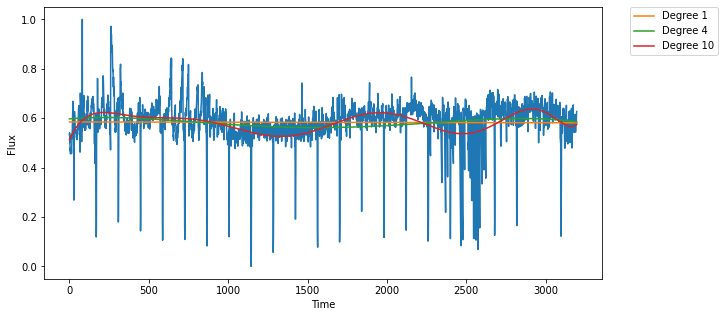

In [9]:
plot_row(train_df, 1)

There is an exoplanet


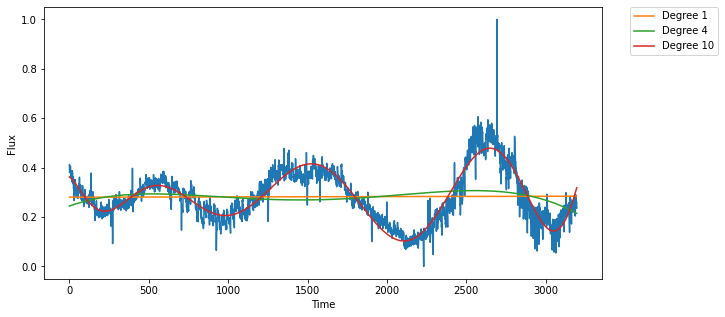

In [17]:
plot_row(train_df, 5)

There's no exoplanet


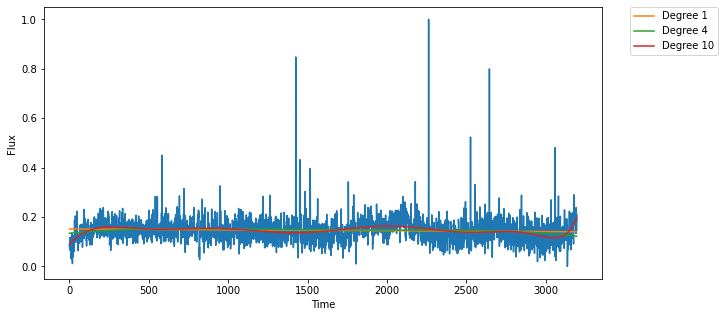

In [13]:
plot_row(train_df, 500)

There's no exoplanet


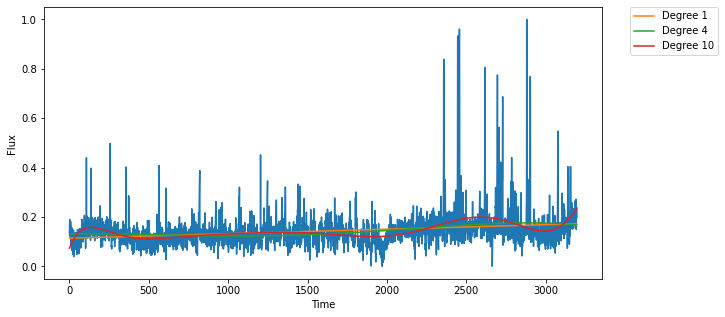

In [20]:
plot_row(train_df, 2000)